# Dask

Dask does two things that NumPy and Pandas don't:
- it allows you to build *task graphs* that set out a plan for executing an operation
- it manages the parallelization of these operations

In practice, this means that you can:
- work with datasets that are larger than memory without needing to micro-manage the file input-output
- operate in parallel
- but still write code that is recognisible from pandas and numpy

Dask is also built into xarray as an optional dependancy.

For reference, the calculations below are carried out on a workstation with 8 CPU cores and 23 GB of memory.

We work mainly with dask.array.  This is the part of dask that can handle multidimensional arrays such as those found in climate science.

In [2]:
import dask.array as da
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

%load_ext autoreload
%autoreload 2

## Task graphs and lazy evaluation
When you call a function on a numpy array, the function is evaluated immediately.  For example:

In [3]:
np.sum( np.random.rand( 10 ) )

4.8614410747326575

This approach of evaluating immediately is known as **eager evaluation**.

When you call a function on a dask array, the function is *not* evaulated immediately.  Instead, calling the function means that dask creates a plan for how it would carry out this operation. This plan is known as a **task graph**. This approach of deferring evaluating is known as **lazy evaluation**.  

The following example shows a simple example where the ultimate computation is to 1) create a random matrix 2) increase all the elements by 1 and 3) add all the elements together.

The task graph image will **not** work on your machine unless [you install special packages to do so.](https://stackoverflow.com/a/43744112/5387991)

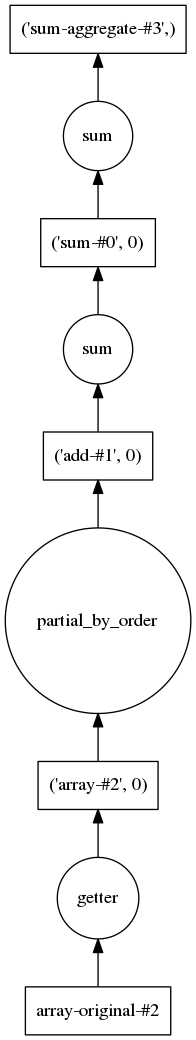

In [4]:
# Define a function that increases all the elements of x by 1
def inc(x):
    return x + 1
# Create a dask array with 9 random elements divided into a single chunk of 9 elements
arr = da.from_array(np.random.rand(9),chunks=(9,))
# Increase all the elements by 1
arr = inc(arr)
# Add all the elements together
arr = da.sum(arr)
# Output the task graph
arr.visualize()

The boxes in the task graph correspond to arrays that are calculated at different points of the calculation.  The circles correspond to functions on the arrays.  The labels used in the task graph can be a bit mysterious.  

At this point the evaluation of the task graph has still not occurred - not even the initial stage of creating the random matrix.

To get dask to trigger the evaluation, use the ```.compute``` method on ```arr```:

In [5]:
arr.compute()

13.132374146178886

Note that the syntax is different when we use dask in xarray. In xarray case the ```.load()``` method triggers the evaluation, but when using dask alone ```.compute()``` triggers execution.

## Automatic parallelisation
Dask also manages the execution of the task graph in parallel.  When executing in parallel you must specify the way that your data should be partitioned - the partions are known as *chunks*.

To illustrate parallel execution, we repeat the calculation above with a random matrix. Previously we set the chunk length to be 9 which is the same as the array length.  As such, the calculation wasn't parallel. However, this time we split the array with 9 total elements into chunks of length 3:

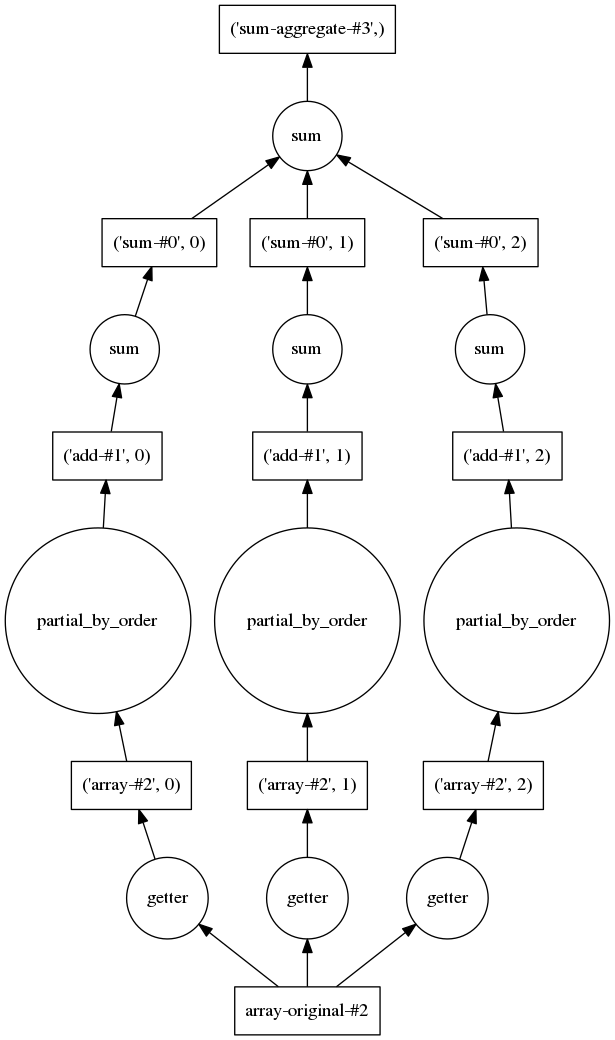

In [7]:
# Define a function that increases all the elements of x by 1
def inc(x):
    return x + 1
# Create a dask array with 9 random elements divided into a chunks with 3 elements
arr = da.from_array(np.random.rand(9),chunks=(3,))
# Increase all the elements by 1
arr = inc(arr)
# Add all the elements together
arr = da.sum(arr)
# Output the task graph
arr.visualize()

Dask now has a task graph that carries out the array creation and incrementing by 1 separately in each of the three chunks.  In the step where the summing of the whole array occurs, dask plans to 1) sum each of the chunks separately to get sub-totals and 2) to sum the the three sub-totals together.  By summing within the chunks the  data that must be transferred around the computer is reduced.

## Advantages and disadvantages of dask
The ability to carry out operations in parallel is clearly an advantage of dask.  However, 
- creating the task graph;
- carrying out calculations on smaller chunks of data; and
- transferring the results of calculations from the chunks to each other

all carry computational cost.  

**If your dataset fits comfortably in memory, it is better to carry out the calculation using numpy.**

We can compare the performance of numpy and dask for such a calculation where the array fits comfortably in memory.

In [165]:
# Numpy example
rand_arr = np.random.rand( 500, 500, 100)
%time np.mean(rand_arr, axis = 1)[0,0];

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 17.9 ms


0.51095482996711228

We can compare this with a similar calculation using dask.  As the array ```rand_arr``` is three dimensional, the chunks argument now needs to have 3 elements with one element for each dimension of ```rand_arr```.

In [166]:
# Dask example where the task graph is created first and we only time the computation
dask_rand_arr = da.from_array( rand_arr, chunks = (100,100,100))
y = da.mean(dask_rand_arr, axis = 1)
%time y.compute()[0,0]

CPU times: user 116 ms, sys: 56 ms, total: 172 ms
Wall time: 37.3 ms


0.5109548299671125

We can inspect the output of the %time magic now that we are using dask.

- the *user* time is the total amount of time the CPUs spent doing the calculation.
- the *sys* time is the overhead for the dask scheduler.  
- the *total* time is the sum of the *user* and *sys* time.
- the *Wall time* is the actual amout of time the calculation took to run.  

The Wall time is much less than the total CPU time when using dask because the CPUs are operating in parallel.

However, in this case the Wall time shows that dask takes twice as long as numpy to do this calculation.


## So when should you think about using dask?

The **real advantages** of dask arise when:
- your dataset is bigger than the memory you have available (in practice dask may start becoming advantageous from when your dataset is more than about 1/3 of your available memory)
- you have multiple cores available on your computer.

As well as doing calculations in parallel, dask also manages the handling of the chunks of data automatically.  This can save time in writing and debugging code to do this yourself.

The following example shows how fast and easy it can be to use dask to do out-of-core processing on a very large array.  In this case the array is 2D and so we need 2 chunks parameters.

In [8]:
# Create very large array that is sampled from a normal distribution with mean zero and standard deviation 1
# Cut the array into 1000x1000 sized chunks
x = da.random.normal(0, 1, size=(200000, 200000),  
                              chunks=(1000, 1000))    

# Print the size of array
print("Size of array x in gigabytes", x.nbytes / 1e9)   

# Take the mean on the first axis (indexing is just to reduce the amount output to the screen)
y = x.mean(axis=0)[0]                          

Size of array x in gigabytes 320.0


In this example we initialise an enourmous array ```x``` that would occupy 320 Gb in memory.  We divide this array into chunks that are each 1000 x 1000 elements.  We then specify that we want to take the mean of this array along the first axis and output a small subset of the outputs.

As we have not yet called ```.compute()``` on ```x``` or ```y```, **none of this has yet happened**.  Instead, dask has created a task graph setting out how it would go about this.

We can now trigger the calculation.  Before doing so for the first time on your machine, it is a good idea to remove some of the zeros from the size of the array ```x``` to check that the calculation won't overwhelm your system.  You can then increase the size of ```x``` when you are sure that your system will not melt down.

In [168]:
%time  y.compute();     # Time to compute the result

CPU times: user 11.2 s, sys: 604 ms, total: 11.8 s
Wall time: 1.68 s


0.0052220194816652507

A wall-clock time of just a few seconds for a calculation on a 320 GB array is quite impressive.  However, a similar calculation on a dataset stored in netcdf files will take much longer.  This longer time is because the data would have to be read from netcdf files on the hard disk, whereas the random array above was just initialised directly in memory.

Be aware that these kinds of performance comparisons generalise poorly to other problems.  The size of the data, the number of cores available and the nature of the calculation all have a major effect on the performance you experience.

## Setting chunk size and shape
The chunk sizes set how the operations are parallelised.  More chunks mean that you get more parallel operations, but also more computational overhead.
Optimum chunk size depends on your system and your problem.  A rule of thumb to start with is to have chunks with size 100 Mb - 500 Mb.

The chunk shape can also affect performance.  If you are taking a mean in the x-direction, for example, then having each chunk span the x-direction can help.

In this example, we compare performance when there are short versus long chunks in the dimension that we are calculating over.

We first define the function, and then check it's performance with different chunk lengths in the dimension that we are calculating over.

In [169]:
def gauss_mean( chunk_tuple ):
    # Create a 4000x3000 array with 300 time steps 
    gauss = da.random.normal(10, 0.1, size=(4000, 3000, 300),   
                              chunks = chunk_tuple)
    # Take mean on first dimension
    out = gauss.mean(axis=0)[::1000]
    return out

We first look at an example with a shorter chunk of with 100 elements in the first dimension and 1000 elements in the second dimension.  Recall that we are taking the mean in the first dimension.

In this case we use the dask's handy progress bar to see how fast the computation is proceeding.

In [170]:
short_chunk = gauss_mean( (100, 1000, 10) )
with ProgressBar():
    short_chunk.compute()    

[########################################] | 100% Completed | 30.2s


Now we look at the performance when we have 1000 elements in the first dimension and 100 elements in the second dimension.

In [171]:
long_chunk = gauss_mean( (1000, 100, 10) )
with ProgressBar():
    long_chunk.compute()    

[########################################] | 100% Completed |  3.2s


In this case the calculation is ten times faster with longer chunking in the dimension we are calculating over.

While the chunk shape and size is important, the performance for your problem may be dominated by how your data is stored on disk.  The time needed to open and close a netcdf file may be as long as the time needed to read the data in the file!  

On account of this file management overhead, if you set your chunk shape and size in such a way that many file openings and closings are required, the file management overhead may overwhelm any performance advantage once the data is in memory.

Ulimately, the right solution will depend on your system and your problem, so you need to experiment with different configuration.  If you will be repeatedly carrying out a certain calculation, you may want to process your netcdf files to have minimise the number of netcdf files you need to open for each calculation.



## Fast fourier transform
Dask also has algorithms to handle some common data analysis operations in parallel.  For example, you can do a fast fourier transform in parallel with dask.

In [172]:
# Set the sampling frequency in seconds
fs = 1 
# Get the length of the signal in seconds
T = 1/fs 
# Set the number of samples
signal_length = 2000 # Number of samples
# Set the time vector
t = T * da.from_array(np.arange(signal_length), chunks= ( signal_length) ) # Time
# Specify a signal and add some random noise
signal = 1.3*np.cos(2*np.pi*t/8) + 0.7*np.cos(2*np.pi*t/20) + np.random.normal(0,1,signal_length) # Signal plus random noise
# Compute the fft with dask
out = da.fft.fft( signal ).compute()

In [9]:
# Create some vectors to plot the output
# Calculate the one-side spectra along with the frequencies
two_sided = abs(out / signal_length )
one_sided = two_sided[:int(0.5*signal_length)]
one_sided[1:-1] = 2*one_sided[1:-1]
freqs = np.arange(int(0.5*signal_length)) / signal_length

NameError: name 'out' is not defined

<IPython.core.display.Javascript object>


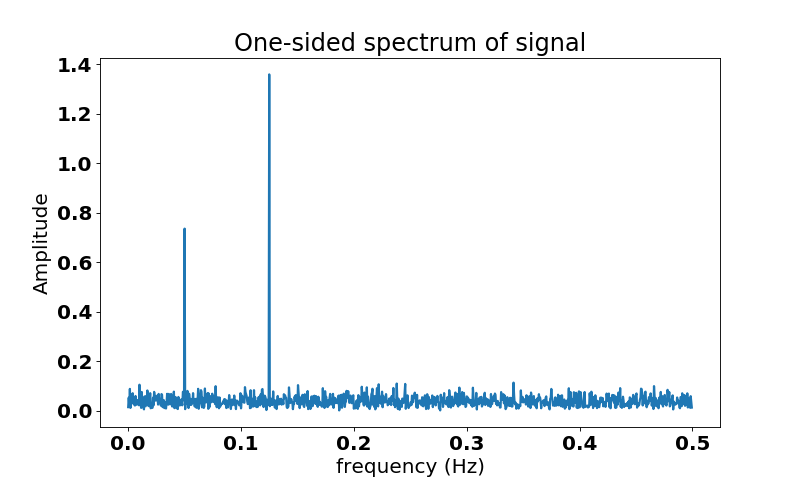

Text(0,0.5,'Amplitude')

In [174]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(freqs, one_sided)
ax.set_title('One-sided spectrum of signal')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Amplitude')

Dask requires that all the data points for the FFT are in a single chunk, so [you may have to *rechunk* your data to do so](http://matthewrocklin.com/blog/work/2017/01/17/dask-images).

## Linear algebra
Dask has also algorithms to parallelise linear algebra operations such as the singular value decomposition using the ```da.linalg``` sub-module.

## Other aspects of dask

We have focused on numpy array-style operations with dask.  Dask also has modules to handle doing pandas-style operations with [dask.dataframe](http://dask.pydata.org/en/latest/dataframe.html) or arbitrary functions with [dask.delayed](http://dask.pydata.org/en/latest/delayed.html).  An emerging feature is the ability to use dask to parallelise [machine learning methods](http://dask.pydata.org/en/latest/machine-learning.html).